In [28]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [29]:
%matplotlib inline

In [30]:
import xgboost
from xgboost import XGBRegressor

In [31]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings
from tqdm import tqdm

In [32]:
from multicam.mah import get_mah

# Load data

In [33]:
mah_data = get_mah('../../data/processed/bolshoi_m12/', cutoff_missing=0.05, cutoff_particle=0.05)

In [34]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
ma = mah_data['ma']
am = mah_data['am']
# ma_peak = mah_data['ma_peak']

indices = mah_data['indices']
scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


## Load merger data

In [35]:
# scale factor coarser bins 
min_scale, max_scale = np.min(scales), np.max(scales)
scale_bins = np.linspace(min_scale, max_scale, 20)
scale_bins

array([0.18635   , 0.22919211, 0.27203421, 0.31487632, 0.35771842,
       0.40056053, 0.44340263, 0.48624474, 0.52908684, 0.57192895,
       0.61477105, 0.65761316, 0.70045526, 0.74329737, 0.78613947,
       0.82898158, 0.87182368, 0.91466579, 0.95750789, 1.00035   ])

In [36]:
# for each simulation scale, get MM 
# first we need merger ratio at every scale 
merger_ratio_inst  = np.zeros((len(cat), len(scales)))
merger_ratio_present = np.zeros((len(cat), len(scales)))
for i in range(len(cat)):
    for j, idx in enumerate(indices): 
        m2_name = f'm2_a{idx}' # TODO: Check what this corresponds to
        cpg_name = f'coprog_mvir_a{idx-1}' # want coprogenitor mass at previous timestep.
        mvir_name = f'mvir_a{idx}'
        
        # get inst ratios
        m2_ratio = cat[m2_name][i].item() / cat[mvir_name][i].item()
        merger_ratio_inst[i, j] = m2_ratio
        
        # present ratios
        m2_ratio = cat[m2_name][i] / cat['mvir'][i].item()
        merger_ratio_present[i, j] = m2_ratio
    

In [37]:
# construct indicator for each halo whether they have a MM in a given scale bine 
Mu = [0.3/1.3, 0.1 / 1.1 , 0.03 / (1 + 0.03), 0.01 / 1.01]
inst_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))
present_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))

# ignore all nanmax warning, these will return np.nan's which is expected. 
warnings.simplefilter("ignore", category=RuntimeWarning)

for kk, mu in enumerate(Mu):
    for jj in range(len(scale_bins) - 1):
        # get largest merger ratio in this scale bin
        mask = (scales >= scale_bins[jj]) & (scales < scale_bins[jj+1])
        inst_mask[kk, :, jj] = np.nanmax(merger_ratio_inst[:, mask], axis=1) > mu
        present_mask[kk, :, jj] = np.nanmax(merger_ratio_present[:, mask], axis=1) > mu

In [38]:
x1 = ma

mask2 = np.isnan(merger_ratio_inst)
x2 = np.where(mask2, 0, merger_ratio_inst)

# use scale_bins instead of scales, take max over mergers in each bin.
x3 = np.zeros((x2.shape[0], scale_bins.shape[0]))
for ii, scale in enumerate(scales):
    jj = np.where(scale >= scale_bins)[0][-1]
    arr = np.vstack([x3[:, jj], x2[:, ii]])
    assert arr.shape == (2, 10000)
    x3[:, jj] = np.max(arr, axis=0)

# Train xgboost to predict concentration

In [39]:
# subsample ma to reduce features every 10 
x = ma[:, ::10]
y = cvir[:, None]

In [40]:
# test train split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((5000, 17), (5000, 1), (2500, 17), (2500, 1), (2500, 17), (2500, 1))

In [41]:
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [42]:
model.fit(x_train, y_train, eval_metric='rmse', verbose=True, eval_set=[(x_val, y_val)], early_stopping_rounds=50)

[0]	validation_0-rmse:8.38488
[1]	validation_0-rmse:7.61696
[2]	validation_0-rmse:6.92536
[3]	validation_0-rmse:6.30623
[4]	validation_0-rmse:5.75102
[5]	validation_0-rmse:5.26180
[6]	validation_0-rmse:4.82520
[7]	validation_0-rmse:4.43851
[8]	validation_0-rmse:4.09119
[9]	validation_0-rmse:3.78376
[10]	validation_0-rmse:3.51988
[11]	validation_0-rmse:3.29116
[12]	validation_0-rmse:3.08568
[13]	validation_0-rmse:2.90559
[14]	validation_0-rmse:2.74985
[15]	validation_0-rmse:2.61210
[16]	validation_0-rmse:2.49985
[17]	validation_0-rmse:2.39805


/Users/imendoza/Library/Caches/pypoetry/virtualenvs/nbody-relaxed-P7T5KfjX-py3.9/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/imendoza/Library/Caches/pypoetry/virtualenvs/nbody-relaxed-P7T5KfjX-py3.9/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-rmse:2.31608
[19]	validation_0-rmse:2.23861
[20]	validation_0-rmse:2.17832
[21]	validation_0-rmse:2.13220
[22]	validation_0-rmse:2.08406
[23]	validation_0-rmse:2.04818
[24]	validation_0-rmse:2.01818
[25]	validation_0-rmse:1.99353
[26]	validation_0-rmse:1.96951
[27]	validation_0-rmse:1.95051
[28]	validation_0-rmse:1.93553
[29]	validation_0-rmse:1.92227
[30]	validation_0-rmse:1.91117
[31]	validation_0-rmse:1.89888
[32]	validation_0-rmse:1.88973
[33]	validation_0-rmse:1.88062
[34]	validation_0-rmse:1.87652
[35]	validation_0-rmse:1.86706
[36]	validation_0-rmse:1.86260
[37]	validation_0-rmse:1.85981
[38]	validation_0-rmse:1.85798
[39]	validation_0-rmse:1.85553
[40]	validation_0-rmse:1.85403
[41]	validation_0-rmse:1.85128
[42]	validation_0-rmse:1.84995
[43]	validation_0-rmse:1.84911
[44]	validation_0-rmse:1.84775
[45]	validation_0-rmse:1.84625
[46]	validation_0-rmse:1.84485
[47]	validation_0-rmse:1.84324
[48]	validation_0-rmse:1.84296
[49]	validation_0-rmse:1.84298
[50]	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [43]:
y_pred = model.predict(x_test)

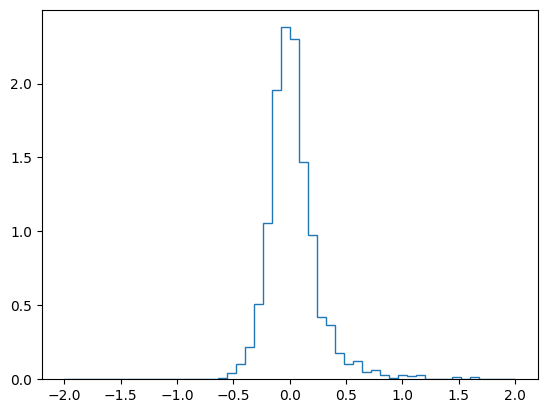

In [44]:
# evaluate by looking at histograms of residuals
res = (y_pred - y_test[:, 0])/y_test[:, 0]
plt.hist(res, bins=50, range=(-2, 2), histtype='step', density=True, label='residuals');

In [45]:
from multicam.correlations import spearmanr
spearmanr(y_test[:, 0], y_pred)

0.836060369033659

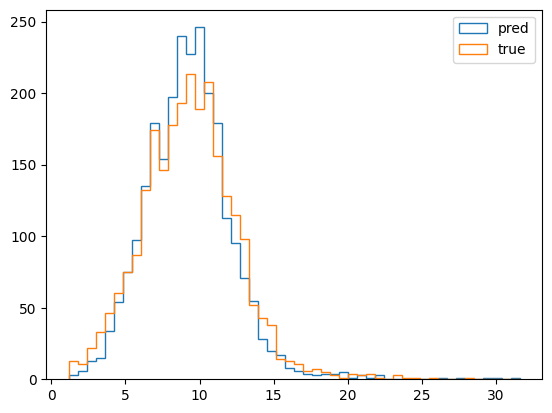

In [46]:
_, bins, _ = plt.hist(y_pred, histtype='step', bins=50, label='pred')
plt.hist(y_test[:, 0], bins=bins, histtype='step', label='true')
plt.legend()

# Predicting concentration with coarse merger information

In [75]:
# subsample ma to reduce features every 10 
x1 = ma[:, ::10]
x = np.concatenate([x1, x3], axis=1)
y = cvir[:, None]

In [76]:
# same initiliazation 
model_m = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [77]:
# test train split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((5000, 37), (5000, 1), (2500, 37), (2500, 1), (2500, 37), (2500, 1))

In [78]:
model_m = model_m.fit(x_train, y_train, eval_metric='rmse', eval_set=[(x_val, y_val)], verbose=True, early_stopping_rounds=50)

[0]	validation_0-rmse:8.38632
[1]	validation_0-rmse:7.60876
[2]	validation_0-rmse:6.91736
[3]	validation_0-rmse:6.30063
[4]	validation_0-rmse:5.74332
[5]	validation_0-rmse:5.24464
[6]	validation_0-rmse:4.80690
[7]	validation_0-rmse:4.42410


/Users/imendoza/Library/Caches/pypoetry/virtualenvs/nbody-relaxed-P7T5KfjX-py3.9/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/imendoza/Library/Caches/pypoetry/virtualenvs/nbody-relaxed-P7T5KfjX-py3.9/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:4.08244
[9]	validation_0-rmse:3.76744
[10]	validation_0-rmse:3.49500
[11]	validation_0-rmse:3.26651
[12]	validation_0-rmse:3.06025
[13]	validation_0-rmse:2.88046
[14]	validation_0-rmse:2.72687
[15]	validation_0-rmse:2.59401
[16]	validation_0-rmse:2.48184
[17]	validation_0-rmse:2.38201
[18]	validation_0-rmse:2.29222
[19]	validation_0-rmse:2.21739
[20]	validation_0-rmse:2.15373
[21]	validation_0-rmse:2.09909
[22]	validation_0-rmse:2.05408
[23]	validation_0-rmse:2.01541
[24]	validation_0-rmse:1.98375
[25]	validation_0-rmse:1.95681
[26]	validation_0-rmse:1.92969
[27]	validation_0-rmse:1.91243
[28]	validation_0-rmse:1.89758
[29]	validation_0-rmse:1.88410
[30]	validation_0-rmse:1.87043
[31]	validation_0-rmse:1.86026
[32]	validation_0-rmse:1.85190
[33]	validation_0-rmse:1.84365
[34]	validation_0-rmse:1.84041
[35]	validation_0-rmse:1.83268
[36]	validation_0-rmse:1.82679
[37]	validation_0-rmse:1.82296
[38]	validation_0-rmse:1.82172
[39]	validation_0-rmse:1.81793
[40]	valid

In [88]:
model_m.best_iteration, model_m.best_score

(117, 1.7678441214903637)

In [84]:
y_pred = model_m.predict(x_test)

In [85]:
from multicam.correlations import spearmanr
spearmanr(y_test[:, 0], y_pred)

0.8505610008577602

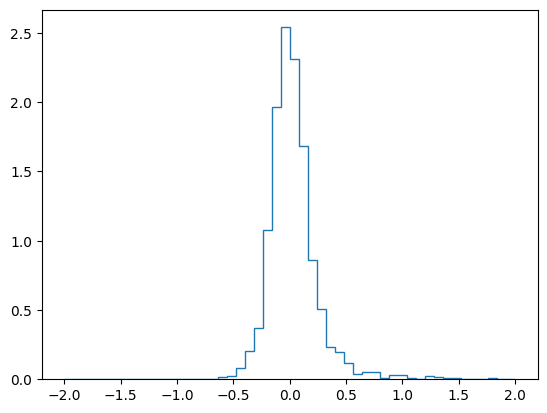

In [86]:
# evaluate by looking at histograms of residuals
res = (y_pred - y_test[:, 0])/y_test[:, 0]
plt.hist(res, bins=50, range=(-2, 2), histtype='step', density=True, label='residuals');

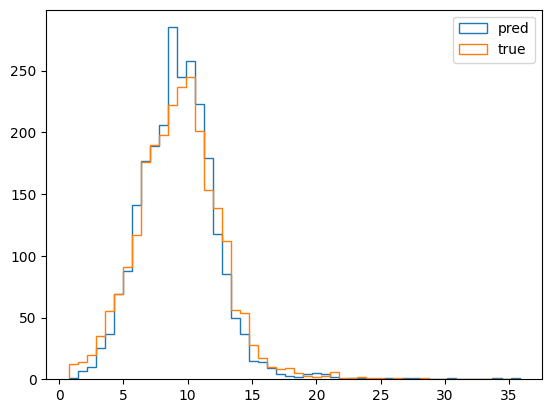

In [87]:
_, bins, _ = plt.hist(y_pred, histtype='step', bins=50, label='pred')
plt.hist(y_test[:, 0], bins=bins, histtype='step', label='true')
plt.legend()